Analysing: 100%|██████████| 25/25 [00:00<00:00, 56.65it/s]


TypeError: <lambda>() missing 1 required positional argument: 'height'

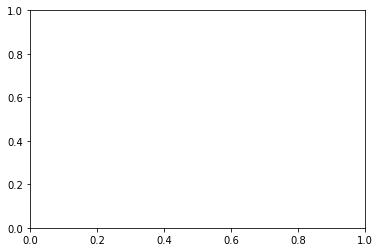

In [11]:
import argparse
import os

import numpy as np
import matplotlib.pyplot as plt

import axelrod
axl = axelrod


def ensure_directory(directory):
    """Makes sure that a directory exists and creates it if it does not."""

    head, tail = os.path.split(directory)
    if head:
        ensure_directory(head)

    if not os.path.isdir(directory):
        os.mkdir(directory)


def axelrod_strategies(cheaters=False, meta=False, transformer=None):
    """Obtains the list of strategies from Axelrod library."""

    s = [s for s in axelrod.all_strategies if axelrod.obey_axelrod(s())]
    if cheaters:
        s.extend(axelrod.cheating_strategies)
    if not meta:
        s = [t for t in s if not (
            t.__name__.startswith("Meta") or t.__name__.startswith("NiceMeta")
        or t.__name__.startswith("NMW"))]
    # Instantiate
    if transformer:
        s = [transformer(t)() for t in s]
    else:
        s = [t() for t in s]
    # Sort by name
    s.sort(key=str)
    return s


def deterministic_strategies():
    """Deterministic Strategies"""
    strategies = []
    for s in axelrod_strategies():
        if not s.classifier["stochastic"]:
            strategies.append(s)
    return strategies


def stochastic_strategies():
    """Stochastic Strategies"""
    strategies = []
    for s in axelrod_strategies():
        if s.classifier["stochastic"]:
            strategies.append(s)
    return strategies


def finite_memory_strategies(lower=0, upper=float('inf')):
    """Filter strategies down to those that have finite memory_depth."""
    strategies = []
    for s in axelrod_strategies():
        memory_depth = s.classifier['memory_depth']
        if memory_depth >= lower and memory_depth < upper:
            strategies.append(s)
    return strategies


def memoryone_strategies():
    """Filter strategies down to those that are memoryone, that is having
    memory_depth 0 or 1."""

    return finite_memory_strategies(lower=0, upper=2)


def tscizzle_strategies():
    """The list of strategies used in @tscizzle's Morality Metrics paper."""

    strategies = [
        axelrod.Cooperator(),
        axelrod.Defector(),
        axelrod.Eatherley(),
        axelrod.Champion(),
        axelrod.GTFT(p=0.1),
        axelrod.GTFT(p=0.3),
        axelrod.GoByMajority(soft=True),
        axelrod.GoByMajority(soft=False),
        axelrod.TitFor2Tats(),
        axelrod.Random(0.8),
        axelrod.Random(0.5),
        axelrod.Random(0.2),
        axelrod.WinStayLoseShift(), # Pavlov
        axelrod.TitForTat(),
        axelrod.TwoTitsForTat(),
        axelrod.Grudger(), # Friedman
        axelrod.Tester(),
        axelrod.SuspiciousTitForTat(),
        axelrod.Joss(0.9),
        axelrod.Joss(0.7),

    ]
    return strategies


def sp_strategies():
    """The list of strategies used in Stewart and Plotkin's 2012 tournament."""

    strategies = [
        axelrod.Cooperator(), # ALLC
        axelrod.Defector(), # ALLD
        axelrod.GTFT(),
        axelrod.GoByMajority(soft=False), # HARD_MAJO
        #axelrod.GoByMajority(soft=True), # SOFT_MAJO
        axelrod.TitFor2Tats(), # TFT2
        axelrod.HardTitFor2Tats(), # HARD_TFT2
        axelrod.Random(), # RANDOM
        axelrod.WinStayLoseShift(), # WSLS
        axelrod.TitForTat(),
        axelrod.HardTitForTat(), # HARD_TFT
        axelrod.Grudger(), # GRIM
        axelrod.Joss(), # HARD_JOSS
        axelrod.ZDGTFT2(),
        axelrod.ZDExtort2(),
        axelrod.Prober(),
        axelrod.Prober2(),
        axelrod.Prober3(),
        axelrod.HardProber(),
        axelrod.Calculator(),
    ]
    return strategies


def random_strategies():
    strategies = []
    for value in numpy.arange(0, 1.05, 0.05):
        strategies.append(axelrod.Random(value))
    return strategies


def all_plots(label, results, filename_suffix, file_format, output_directory):
    """Obtain all plots"""
    plot = axl.Plot(results)

    f = plot.boxplot(title="Payoff " + label)
    filename = os.path.join(output_directory,
                            "{}_boxplot.{}".format(filename_suffix, file_format))
    f.savefig(filename)
    plt.close(f)

    f = plot.payoff(title="Payoff " + label)
    filename = os.path.join(output_directory,
                            "{}_payoff.{}".format(filename_suffix, file_format))
    f.savefig(filename)
    plt.close(f)

    f = plot.winplot(title="Wins " + label)
    filename = os.path.join(output_directory,
                            "{}_winplot.{}".format(filename_suffix, file_format))
    f.savefig(filename)
    plt.close(f)

    f = plot.sdvplot(title="Payoff differences " + label)
    filename = os.path.join(output_directory,
                            "{}_sdvplot.{}".format(filename_suffix, file_format))
    f.savefig(filename)
    plt.close(f)

    f = plot.pdplot(title="Payoff differences " + label)
    filename = os.path.join(output_directory,
                            "{}_pdplot.{}".format(filename_suffix, file_format))
    f.savefig(filename)
    plt.close(f)


def run_tournament(name, strategies, repetitions=100, turns=200, noise=0,
                   processes=None):
    if not processes:
        processes = 3

    # Make sure the output directories exist
    root_directory = os.path.join("assets", "tournaments")
    output_directory = os.path.join(root_directory, name)
    ensure_directory(output_directory)

    # Set up a tournament manager
    tournament = axelrod.Tournament(strategies, turns=turns,
                                    repetitions=repetitions,
                                    noise=noise)
    results = tournament.play(processes=processes)
    # Make the plots
    all_plots(label=name, results=results, filename_suffix=name,
              file_format="svg", output_directory=output_directory)
    return results


def parse_args():
    parser = argparse.ArgumentParser(description="Run Sample Axelrod tournaments")

    parser.add_argument(
        '-t',
        '--turns',
        type=int,
        default=200,
        help='turns per pair')

    parser.add_argument(
        '-r', '--repetitions',
        type=int,
        default=10,
        help='round-robin repetitions')

    parser.add_argument(
        '-p', '--processes',
        type=int,
        default=None,
        help='Number of parallel processes to spawn. 0 uses cpu count.')

    parser.add_argument(
        '-n', '--noise',
        type=float,
        default=0,
        help='Noise level')

    parser.add_argument(
        '-a',
        "--all_strategies",
        action='store_true',
        dest="all_strategies",
        help='Run just the all strategies tournament')

    args = parser.parse_args()

    return (args.turns, args.repetitions, args.processes, args.noise,
            args.all_strategies)


if __name__ == "__main__":
#     turns, repetitions, processes, noise, all_strategies = parse_args()

#     if all_strategies:
#         strategies_names = [(axelrod_strategies(cheaters=False), "AllFairStrategies")]
#     else:
#         strategies_names = [
#             (deterministic_strategies(), "Deterministic"),
#             (stochastic_strategies(), "Stochastic"),
#             (memoryone_strategies(), "Memoryone"),
#             (finite_memory_strategies(), "FiniteMemory"),
#             (tscizzle_strategies(), "tscizzle"),
#             (sp_strategies(), "StewartPlotkin2012")
#             ]
#     for strategies, name in strategies_names:
#         if noise:
#             name += "-noise"
    plt.bar(np.mean((run_tournament('name', [axl.TidemanAndChieruzzi(),axl.TitForTat(),axl.Grudger(),axl.Random(0.5),axl.Nydegger(),axl.Grofman(),axl.Shubik(),axl.SteinAndRapoport(),axl.Davis(),
           axl.SneakyTitForTat(),axl.RevisedDowning(),axl.Feld(),axl.Joss(),axl.Tullock(),axl.UnnamedStrategy()]).normalised_scores),axis = 1))

In [6]:
plt.show()